In [39]:
import numpy as np


def SNR(x, x_recon):
    avg_x2 = np.average(x * x)
    avg_error2 = np.average((x_recon - x) * (x_recon - x))
    return 10 * np.log10(avg_x2 / avg_error2)


Fs = 16000
T = 0.1
f = 2100
t_sample = np.arange(0.0, T, 1 / Fs)

# uniform sampling from -50 ~ 0 dB, in 0.1 dB increments
P_sample = np.arange(-50, 0, 0.1)
log_A_sample = P_sample / 20
A_sample = np.power(10, log_A_sample)

x_sample = [A * np.sin(2 * np.pi * f * t_sample) for A in A_sample]

In [25]:
from quantize import (
    vQuantizeUniform,
    vDequantizeUniform,
    ScaleFactor,
    MantissaFP,
    DequantizeFP,
    Mantissa,
    Dequantize,
)
import matplotlib.pyplot as plt

In [40]:
# 6 bits midtread
nBits = 6
x_recon_sample = [
    vDequantizeUniform(vQuantizeUniform(x, nBits), nBits) for x in x_sample
]
snr_MT6 = [SNR(x, x_recon) for x, x_recon in zip(x_sample, x_recon_sample)]

# 12 bits midtread
nBits = 12
x_recon_sample = [
    vDequantizeUniform(vQuantizeUniform(x, nBits), nBits) for x in x_sample
]
snr_MT12 = [SNR(x, x_recon) for x, x_recon in zip(x_sample, x_recon_sample)]

# 3 scale bits, 5 mantissa bits floating point midtread
x_recon_sample = [
    [
        DequantizeFP(ScaleFactor(x_sub), MantissaFP(x_sub, ScaleFactor(x_sub)))
        for x_sub in x
    ]
    for x in x_sample
]
snr_FP35 = [SNR(x, x_recon) for x, x_recon in zip(x_sample, x_recon_sample)]

# 3 scale bits, 5 mantissa bits block floating point midtread (N = 1)
x_recon_sample = [
    [Dequantize(ScaleFactor(x_sub), Mantissa(x_sub, ScaleFactor(x_sub))) for x_sub in x]
    for x in x_sample
]
snr_BFP35 = [SNR(x, x_recon) for x, x_recon in zip(x_sample, x_recon_sample)]

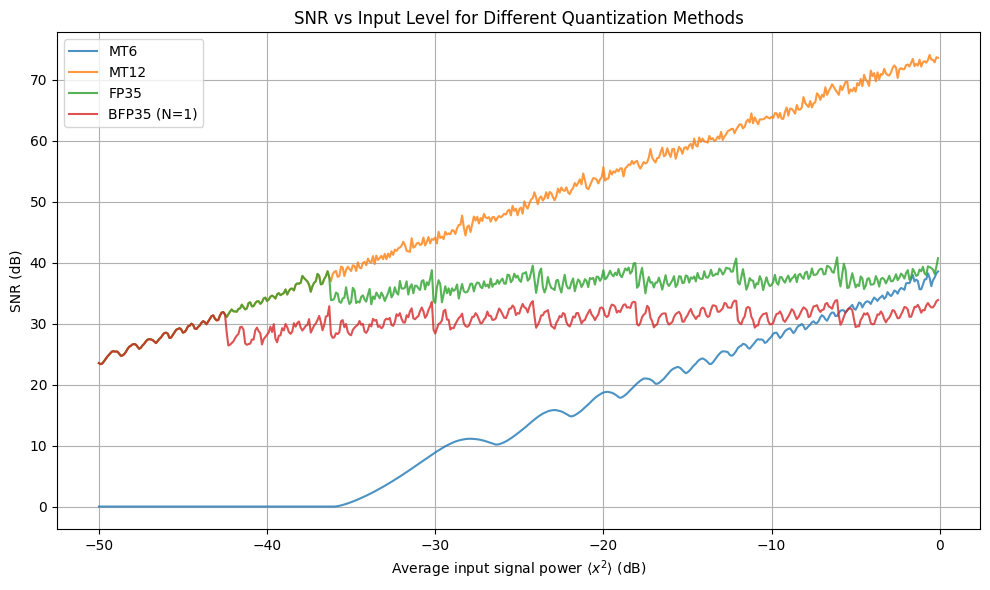

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(P_sample, snr_MT6, label="MT6", alpha=0.8)
plt.plot(P_sample, snr_MT12, label="MT12", alpha=0.8)
plt.plot(P_sample, snr_FP35, label="FP35", alpha=0.8)
plt.plot(P_sample, snr_BFP35, label="BFP35 (N=1)", alpha=0.8)
plt.title("SNR vs Input Level for Different Quantization Methods")
plt.xlabel("Average input signal power $\\langle x^2 \\rangle$ (dB)")
plt.ylabel("SNR (dB)")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()